<a href="https://colab.research.google.com/github/Sathush3/collab/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Download

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-06-23 18:25:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   259MB/s    in 0.3s    

2022-06-23 18:25:01 (259 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



unzip and set the directories

In [6]:
import os
import zipfile
with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/catsdogs')
base_dir = '/content/cats_dogs/dataset'
train_dir = os.path.join(base_dir, 'training_set')
validation_dir = os.path.join(base_dir, 'test_set')

In [6]:
import tensorflow as tf
from tensorflow import keras
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

loading training and validation dataset

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(150, 150))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Data Preprocessing

data augmentation by random flipping
When you apply augmentation to a training set, you’re preventing overfitting, because augmentation exposes different aspects of the image to the model.

In [9]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

checking result of the augmentaion

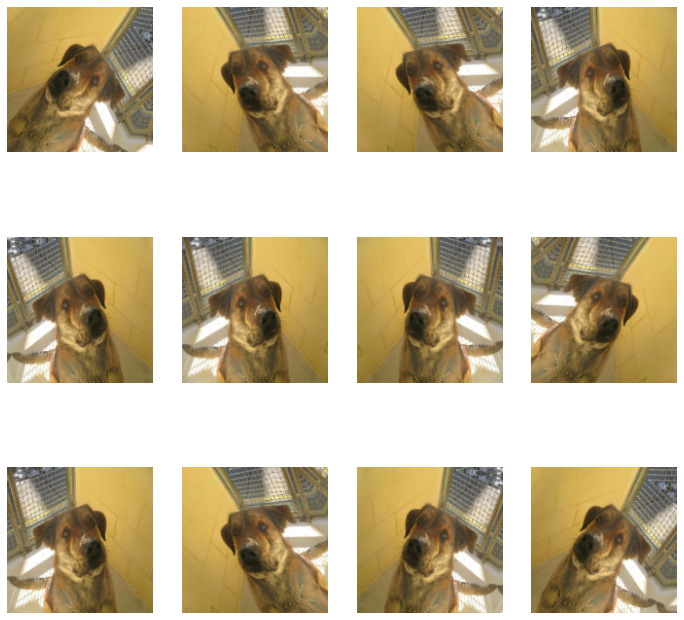

In [10]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

# Creating a base model from pre-trained Mobilenet model

using the model trained on imagenet dataset
`include_top=False` means that we're not interested in the last layer of the model. Since models are visualized from bottom to top, that layer is referred to as the top layer. Excluding the top layers is important for feature extraction.

In [11]:
base_model = keras.applications.MobileNetV3Large(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False) 

12697600/12683000 [==============================] - 0s 0us/step


freeze the base model layers so that they’re not updated during the training process. 

Since many pre-trained models have a `tf.keras.layers.BatchNormalization` layer, it’s important to freeze those layers. Otherwise, the layer mean and variance will be updated, which will destroy what the model has already learned. 

In [12]:
base_model.trainable = False

# Create the final dense layer

When loading the model, you used `include_top=False` meaning that the final dense layer of the pre-trained model wasn’t included. Now it’s time to define a final output layer for this model. 

In [13]:
inputs = keras.Input(shape=(150, 150, 3))

apply data augmentation

In [14]:
x = data_augmentation(inputs)

In [15]:
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)

Let’s now define the model as follows:

ensure that the base model is running in inference mode so that batch normalization layers are not updated during the fine-tuning stage (set `training=False`);
convert features from the base model to vectors, using `GlobalAveragePooling2D`;
apply dropout regularization;
add a final dense layer (when you used `include_top=False,` the final output layer was not included, so you have to define your own).

In [16]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Train the model

train the top layer
accuracy starts high coz pre trained model

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())
history = model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
63/63 [==============================] - 14s 138ms/step - loss: 0.0116 - binary_accuracy: 0.9955 - val_loss: 0.0670 - val_binary_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 8s 125ms/step - loss: 0.0061 - binary_accuracy: 0.9975 - val_loss: 0.1330 - val_binary_accuracy: 0.9790
Epoch 3/20
63/63 [==============================] - 8s 124ms/step - loss: 0.0184 - binary_accuracy: 0.9950 - val_loss: 0.1327 - val_binary_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 9s 138ms/step - loss: 0.0243 - binary_accuracy: 0.9915 - val_loss: 0.1015 - val_binary_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 8s 125ms/step - loss: 0.0075 - binary_accuracy: 0.9970 - val_loss: 0.1024 - val_binary_accuracy: 0.9810
Epoch 6/20
63/63 [==============================] - 9s 133ms/step - loss: 0.0030 - binary_accuracy: 0.9995 - val_loss: 0.0753 - val_binary_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 8s 126ms/st

learning curves

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: ignored

# Fine-tuning the model

The model can be improved by unfreezing the base model, and retraining it on a very low learning rate. 

You need to monitor this step because the wrong implementation can lead to overfitting

In [18]:
base_model.trainable = True

After updating the trainable attribute, the model has to be compiled again to implement the change.

In [19]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=keras.metrics.BinaryAccuracy())

To prevent overfitting, let’s monitor training loss via a callback. Keras will stop training when the model doesn’t improve for five consecutive epochs. Let’s also use TensorBoard to monitor loss and accuracy.

In [21]:
rm -rf logs

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

retrain the model.

In [23]:
model.fit(training_set, epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 17s 147ms/step - loss: 0.0575 - binary_accuracy: 0.9750 - val_loss: 0.0733 - val_binary_accuracy: 0.9670
Epoch 2/15
63/63 [==============================] - 8s 123ms/step - loss: 0.0447 - binary_accuracy: 0.9830 - val_loss: 0.0711 - val_binary_accuracy: 0.9690
Epoch 3/15
63/63 [==============================] - 8s 127ms/step - loss: 0.0429 - binary_accuracy: 0.9800 - val_loss: 0.0718 - val_binary_accuracy: 0.9680
Epoch 4/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0385 - binary_accuracy: 0.9865 - val_loss: 0.0684 - val_binary_accuracy: 0.9730
Epoch 5/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0386 - binary_accuracy: 0.9845 - val_loss: 0.0662 - val_binary_accuracy: 0.9710
Epoch 6/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0339 - binary_accuracy: 0.9860 - val_loss: 0.0671 - val_binary_accuracy: 0.9710
Epoch 7/15
63/63 [==============================] - 8s 125ms/st